In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sb
import matplotlib.pyplot as plt
import neattext.functions as nfx
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Collection

## For code, see DataCollection.ipynb

In [2]:
# titles have already been stemmed and lemmatized
df = pd.read_csv('training_data.csv')
df_test = pd.read_csv('testing_data.csv') # used at the very end 

In [6]:
print(df[df['label'] == 'snarxiv'].count())
print(df[df['label'] == 'arxiv'].count())
print(df_test[df_test['label'] == 'snarxiv'].count())
print(df_test[df_test['label'] == 'arxiv'].count())

title    395
label    395
dtype: int64
title    394
label    394
dtype: int64
title    100
label    100
dtype: int64
title    100
label    100
dtype: int64


# Feature Engineering

## Simple features

In [3]:
special_char = ['^', '=', '$', '{', '}', '+' ,'-', '*', '/', '\\', '$', '#']
df['ContainsSpecialChar'] = df['title'].str.contains('|'.join(map(re.escape, special_char)))
df['ContainsNumber'] = df['title'].str.contains(r'\d', regex=True)
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['length'] = df['title'].str.len()

## Cosine Similarity

In [4]:
snarxiv = df[df['label'] == 'snarxiv']
arxiv = df[df['label'] == 'arxiv']

tfidf_vectorizer = TfidfVectorizer()
result_vec = tfidf_vectorizer.fit_transform(snarxiv['title'].values.tolist())
snarxiv_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

vect_list = snarxiv_vect.values.tolist()

avg_cos_sim_list = []
for i in range(len(vect_list)):
    store_avg_cos_sim = []
    for row in range(len(vect_list)):
        if i != row:
            cos_sim = cosine_similarity([vect_list[i]], [vect_list[row]])
            store_avg_cos_sim.append(cos_sim)
    avg_cos_sim = sum(store_avg_cos_sim) / len(store_avg_cos_sim)
    avg_cos_sim_list.append(avg_cos_sim)
    
snarxiv_cos_sim_list = [i[0] for i in avg_cos_sim_list]
snarxiv_cos_sim_df = pd.DataFrame(snarxiv_cos_sim_list)

result_vec = tfidf_vectorizer.transform(arxiv['title'].values.tolist())
arxiv_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())
arxiv_list = arxiv_vect.values.tolist()

avg_cos_list = []
for i in range(len(arxiv_list)):
    store_avg = []
    for j in range(len(vect_list)):
        cos = cosine_similarity([arxiv_list[i]], [vect_list[j]])
        store_avg.append(cos)
    avg = sum(store_avg) / len(store_avg)
    avg_cos_list.append(avg)
    
arxiv_cos_sim_list = [i[0] for i in avg_cos_list]
arxiv_cos_sim_df = pd.DataFrame(arxiv_cos_sim_list)

cos_sim_concat = pd.concat([snarxiv_cos_sim_df, arxiv_cos_sim_df])

/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
cos_sim_concat = cos_sim_concat.reset_index()
df = pd.concat([df, cos_sim_concat], axis = 1)
df = df.rename(columns={0: "cos_sim"})

## Rare Words

In [6]:
eng_dict = pd.read_csv('unigram_freq.csv')
eng_list = eng_dict['word'].to_list()

# creating a dictionary of physics words
df['split_txt'] = [x.split(' ') for x in df['title']]
f1_words = df['split_txt'].tolist()
f1_words_list = [item for row in f1_words for item in row]
words_list = list(filter(None,f1_words_list))

words_list_no_dupe = list(set(words_list))

f1_word_dict = dict.fromkeys(words_list_no_dupe, 0)

for word in f1_word_dict:
    for title in f1_words:
        if word in title:
            f1_word_dict[word] += 1
f1_word_dict_norm = {key: value / df.index.size for key, value in f1_word_dict.items()}

fold_dict = {}

def rare_words_check(split_txt):
    count = 0
    for word in split_txt:
        if word not in combined_word_dict:
            count += 1
    return count 

dictionary = {key: value for key, value in f1_word_dict_norm.items() if value >= 3/len(df)}
keys = list(dictionary.keys())
combined_word_dict = keys + eng_list 

df['rare_word'] = df['split_txt'].apply(rare_words_check)

## Convert titles to vectors

In [7]:
df = df[['title', 'cos_sim', 'ContainsSpecialChar', 'ContainsNumber', 'title_word_count',
        'length', 'rare_word','label']]

In [8]:
vectorizer = TfidfVectorizer()
result_vec = vectorizer.fit_transform(df['title'].values.tolist())
count_vect_df = pd.DataFrame(result_vec.todense(), columns=vectorizer.get_feature_names())
count_concat = pd.concat([count_vect_df, df[['cos_sim', 'ContainsSpecialChar', 'ContainsNumber', 
                                             'title_word_count', 'length', 
                                             'rare_word', 'label']].reset_index()], axis = 1)
count_concat = count_concat.drop(columns = 'index')

/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Normalizing features

In [9]:
cos_mean = count_concat['cos_sim'].mean()
cos_std = count_concat['cos_sim'].std()
count_concat['cos_sim'] = (count_concat['cos_sim'] - cos_mean) / cos_std

count_concat['ContainsSpecialChar'] = count_concat['ContainsSpecialChar'].astype(int)

count_concat['ContainsNumber'] = count_concat['ContainsNumber'].astype(int)

title_mean = count_concat['title_word_count'].mean()
title_std = count_concat['title_word_count'].std()
count_concat['title_word_count'] = (count_concat['title_word_count'] - title_mean) / title_std

len_mean = count_concat['length'].mean()
len_std = count_concat['length'].std()
count_concat['length'] = (count_concat['length'] - len_mean) / len_std

rare_mean = count_concat['rare_word'].mean()
rare_std = count_concat['rare_word'].std()
count_concat['rare_word'] = (count_concat['rare_word'] - rare_mean) / rare_std

In [10]:
count_concat.head(3)

,02,07050143,16,1dimensional,1duality,26,2d,2folds,2loop,2point,...,zm,γγ,λq,cos_sim,ContainsSpecialChar,ContainsNumber,title_word_count,length,rare_word,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.972017,0,1,-0.728168,-0.448572,0.625075,snarxiv
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.685259,0,0,2.585817,2.532380,-0.679645,snarxiv
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.767152,0,0,1.983275,2.127559,0.625075,snarxiv


# Model Creation

In [11]:
X = count_concat.drop(['label'], axis=1)
y = count_concat[['label']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,random_state = 395786)

In [12]:
# Create the Logistic Regression classifier
logistic_classifier = LogisticRegression()

# Perform cross-validation
cv_scores = cross_val_score(logistic_classifier, X_train, y_train.values.ravel(), cv=5)  # Adjust cv as needed

# Fit the model on the entire training set
logistic_classifier.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred = logistic_classifier.predict(X_test)

# Calculate accuracy on the test set
lg_accuracy_norare = accuracy_score(y_test, y_pred)

# Print cross-validated scores
print("Cross-validated scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Print accuracy on the test set
print("Accuracy on test set:", lg_accuracy_norare)

Cross-validated scores: [0.81512605 0.81355932 0.77966102 0.75423729 0.77966102]
Mean CV accuracy: 0.788448938897593
Accuracy on test set: 0.797979797979798


In [13]:
dt_classifier = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3,4,5,6,7,8],
    'min_samples_split': [1,2,3,4,5],
    'min_samples_leaf': [1,2,3,4,5]
}
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train.values.ravel())
best_dt_classifier = grid_search.best_estimator_
y_pred = best_dt_classifier.predict(X_test)
dt_accuracy_norare = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
report_df = pd.DataFrame(list(report.split('\n')))
report_df = report_df.rename(columns={0: 'Metrics'})
report_df = report_df[report_df['Metrics'] != '']
print(dt_accuracy_norare)
print(report_df)

0.7626262626262627
                                             Metrics
0                precision    recall  f1-score   ...
2         arxiv       0.75      0.81      0.78   ...
3       snarxiv       0.78      0.71      0.75   ...
5      accuracy                           0.76   ...
6     macro avg       0.76      0.76      0.76   ...
7  weighted avg       0.76      0.76      0.76   ...


/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_spl

In [14]:
svm_classifier = SVC(kernel='linear', probability=True)
cv_scores = cross_val_score(svm_classifier, X_train, y_train.values.ravel(), cv=5) 
svm_classifier.fit(X_train, y_train.values.ravel())
y_pred = svm_classifier.predict(X_test)
svm_accuracy_norare = accuracy_score(y_test, y_pred)
print("Cross-validated scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Accuracy on test set:", svm_accuracy_norare)

Cross-validated scores: [0.78151261 0.88135593 0.83050847 0.83050847 0.86440678]
Mean CV accuracy: 0.8376584532117931
Accuracy on test set: 0.8585858585858586


# Playing the game using the SVM model

## Copy and paste the titles into the data frame below:

In [15]:
game = {'title': ['Improvement of the Theta+ Width Estimation Method on the Light Cone',
                  'Cosmic Rays at the Planck Scale and a Nonstandard Solution of Exclusive Models of Inflation']}
game_df = pd.DataFrame(game)

In [16]:
game_df['title'] = game_df['title'].apply(nfx.remove_stopwords)
game_df['title'] = game_df['title'].apply(nfx.remove_punctuations)
game_df = game_df.apply(lambda x: x.astype(str).str.lower())

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

game_df['title'] = game_df['title'].map(lemmatize_text)

eng_dict = pd.read_csv('unigram_freq.csv')
eng_list = eng_dict['word'].to_list()

# make fitted vectorized data
# this is snarxiv titles for cosine similarity 
snarxiv = df[df['label'] == 'snarxiv']
arxiv = df[df['label'] == 'arxiv']

tfidf_vectorizer = TfidfVectorizer()
result_vec = tfidf_vectorizer.fit_transform(snarxiv['title'].values.tolist())
snarxiv_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

vect_list = snarxiv_vect.values.tolist()

# tips
# vect_list is snarxiv
# arxiv_list is arxiv 

result_vec = tfidf_vectorizer.transform(game_df['title'].values.tolist())
game_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

avg_cos_sim_list = []
for i in [0, 1]:
    store_cos_sim = []
    for j in range(len(vect_list)):
        cos_sim = cosine_similarity([vect_list[j]], [game_vect.values.tolist()[i]])
        store_cos_sim.append(cos_sim)
    avg_cos_sim = sum(store_cos_sim) / len(store_cos_sim)
    avg_cos_sim_list.append(avg_cos_sim)
cos_sim_list = [i[0] for i in avg_cos_sim_list]
cos_sim_df = pd.DataFrame(cos_sim_list)

game_df = pd.concat([game_df, cos_sim_df], axis = 1)
game_df = game_df.rename(columns={0: "cos_sim"})

def rare_words_check(split_txt):
    count = 0
    for word in split_txt:
        if word not in combined_word_dict:
            count += 1
    return count 

game_df['split_txt'] = [x.split(' ') for x in game_df['title']]
game_df['rare_word'] = game_df['split_txt'].apply(rare_words_check)

special_char = ['^', '=', '$', '{', '}', '+' ,'-', '*', '/', '\\', '$', '#']
game_df['ContainsSpecialChar'] = game_df['title'].str.contains('|'.join(map(re.escape, special_char)))
game_df['ContainsNumber'] = game_df['title'].str.contains(r'\d', regex=True)
game_df['title_word_count'] = game_df['title'].apply(lambda x: len(str(x).split()))
game_df['length'] = game_df['title'].str.len()

game_df = game_df[['title', 'cos_sim', 'rare_word', 'ContainsSpecialChar', 'ContainsNumber',
                  'title_word_count', 'length']]



game_vec = vectorizer.transform(game_df['title'].values.tolist())
game_vect = pd.DataFrame(game_vec.todense(), columns=vectorizer.get_feature_names())

game_concat = pd.concat([game_vect, game_df[['cos_sim', 'ContainsSpecialChar', 'ContainsNumber', 
                                             'title_word_count', 'length', 
                                             'rare_word']].reset_index()], axis = 1)

game_concat = game_concat.drop(columns = 'index')

game_concat['cos_sim'] = (game_concat['cos_sim'] - cos_mean) / cos_std

game_concat['ContainsSpecialChar'] = game_concat['ContainsSpecialChar'].astype(int)

game_concat['ContainsNumber'] = game_concat['ContainsNumber'].astype(int)

if title_std != 0:
    game_concat['title_word_count'] = (game_concat['title_word_count'] - title_mean) / title_std

if len_std != 0:
    game_concat['length'] = (game_concat['length'] - len_mean) / len_std

if rare_std != 0:
    game_concat['rare_word'] = (game_concat['rare_word'] - rare_mean) / rare_std
    
y_pred = svm_classifier.predict(game_concat)
probabilities = svm_classifier.predict_proba(game_concat)
print(y_pred)
print(probabilities) 

/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['arxiv' 'snarxiv']
[[0.5596131 0.4403869]
 [0.0062932 0.9937068]]


/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Error Analysis

## Below is a table of all the wrong guesses
### If the label is 'arxiv', that means the model guessed snarxiv, but it was actually arxiv
### If the label is 'snarxiv', that means the model guessed arxiv, but it was actually snarxiv

In [17]:
wrong = [['Large Lepton Flavor Mixings in $SU(6) Imes SU(2)_R$ Model', 'arxiv'],
['Monstrous Moonshine Implements a Non-gauge Mediated Reduction of a Non-low-scale Model With Neutralinos', 'arxiv'],
['A Unified Model for Inelastic E-N and Nu-N Cross Sections at All Q2', 'arxiv'],
['Using and Constraining Nonforward Parton Distributions (Deeply Virtual   Neutrino Scattering in Cosmic Rays and Light Dark Matter Searches)', 'arxiv'],
['A New Determination of the QED Coupling Alpha(M_Z^2) Lets the Higgs Off   the Hook', 'arxiv'],
['The Effective Action of N=8 Supergravity', 'arxiv'],
['Upper Bound on the Mass Scale of Superpartners in Minimal N=2   Supersymmetry', 'arxiv'],
['Confinement and the Second Vortex of the SU(4) Gauge Group', 'arxiv'],
['Reconstructing Non-abelian Gerbs: Tensor Networks During Inflation', 'arxiv'],
['The March Towards No-scale Supergravity', 'arxiv'],
['Brane Solutions of a Spherical Sigma Model in Six Dimensions', 'arxiv'],
['CP Asymmetry in $B  O Phi K_S$ in a General Two-Higgs-doublet Model   With Fourth-generation Quarks', 'arxiv'],
['Charmonium Suppression by Gluon Bremsstrahlung in P-A and A-B Collisions', 'arxiv'],
['72 Years of Debate With Dirac-Glashow', 'snarxiv'],
['Comments on Large Logarithms', 'snarxiv'],
['Towards Tomita-Takesaki Theory in Weak-dissipative Inflation', 'snarxiv'],
['Comment on a Proposal by Susskind', 'snarxiv'],
['Conformal Algebras in String Theory in the Presence of Hypersurface Defects', 'snarxiv'],
['Towards the Low-energy Limit', 'snarxiv'],
['Scalar Mechanics Implemented via Path Integrals', 'snarxiv'],
['Vanishing Clebsch-Gordon Decomposition', 'snarxiv'],
['Exploring Duality: A Broken Yangian Symmetric Technique', 'snarxiv'],
['Comments on String Theory ', 'snarxiv'],
['The Analytic Continuation of Topological String Theory Supported on CY_8', 'snarxiv'],
['Conifold Singularities', 'snarxiv'],
['The HRT Surface Discovered Using Hilbert Schemes', 'snarxiv'],
['String Theories ', 'snarxiv'],
['Stable Monopoles Are Inverted Inflationary', 'snarxiv'],
['Hypersurface Defects', 'snarxiv'],
['Superconvergence Sum Rules', 'snarxiv'],
['Discrete Boundary-dualities', 'snarxiv'],
['Condensate Remnants', 'snarxiv'],
['UV Behavior in Variable Mass Hydrodynamics', 'snarxiv'],
['33 Years of Debate With Lorentz-Einstein', 'snarxiv'],
['Soft Theorems in F-Theory Deformed by Hypersurface Operators', 'snarxiv'],
['Black Hole Complementarity', 'snarxiv'],
['Comments on Symplectic Quotients on C^n', 'snarxiv'],
['On Anomaly Matching', 'snarxiv'],
['Perturbation Theory on Superspace Derived via E_6 Characters', 'snarxiv'],
['Towards Considering String Theories ', 'snarxiv']]

wrong_df = pd.DataFrame(wrong, columns=['title', 'label'])


In [18]:
wrong_df['title'] = wrong_df['title'].apply(nfx.remove_stopwords)
wrong_df['title'] = wrong_df['title'].apply(nfx.remove_punctuations)
wrong_df = wrong_df.apply(lambda x: x.astype(str).str.lower())

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

wrong_df['title'] = wrong_df['title'].map(lemmatize_text)

wrong_df['title_word_count'] = wrong_df['title'].apply(lambda x: len(str(x).split()))
wrong_df['length'] = wrong_df['title'].str.len()
wrong_df['split_txt'] = [x.split(' ') for x in wrong_df['title']]
wrong_df['rare_word'] = wrong_df['split_txt'].apply(rare_words_check)

# make fitted vectorized data
# this is snarxiv titles for cosine similarity 
snarxiv = df[df['label'] == 'snarxiv']
arxiv = df[df['label'] == 'arxiv']

tfidf_vectorizer = TfidfVectorizer()
result_vec = tfidf_vectorizer.fit_transform(snarxiv['title'].values.tolist())
snarxiv_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

vect_list = snarxiv_vect.values.tolist()

# tips
# vect_list is snarxiv
# arxiv_list is arxiv 


result_vec = tfidf_vectorizer.transform(wrong_df['title'].values.tolist())
wrong_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

avg_cos_sim_list = []
for i in range(len(wrong_df)):
    store_cos_sim = []
    for j in range(len(vect_list)):
        cos_sim = cosine_similarity([vect_list[j]], [wrong_vect.values.tolist()[i]])
        store_cos_sim.append(cos_sim)
    avg_cos_sim = sum(store_cos_sim) / len(store_cos_sim)
    avg_cos_sim_list.append(avg_cos_sim)
cos_sim_list = [i[0] for i in avg_cos_sim_list]
cos_sim_df = pd.DataFrame(cos_sim_list)

wrong_df = pd.concat([wrong_df, cos_sim_df], axis = 1)
wrong_df = wrong_df.rename(columns={0: "cos_sim"})

/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
print('predicted snarxiv, but was actually arxiv: ', len(wrong_df[wrong_df['label'] == 'arxiv']))
print('predicted arxiv, but was actually snarxiv: ', len(wrong_df[wrong_df['label'] == 'snarxiv']))

predicted snarxiv, but was actually arxiv:  13
predicted arxiv, but was actually snarxiv:  27


In [20]:
print('predicted snarxiv but actually arxiv mean word count: ',wrong_df[wrong_df['label'] == 'arxiv']['title_word_count'].mean())
print('training snarxiv mean word count: ', snarxiv['title_word_count'].mean())
print(' ')
print('predicted arxiv but actually snarxiv mean word count: ',wrong_df[wrong_df['label'] == 'snarxiv']['title_word_count'].mean())
print('training arxiv mean word count: ', arxiv['title_word_count'].mean())
print(' ')
print('predicted snarxiv but actually arxiv mean length: ',wrong_df[wrong_df['label'] == 'arxiv']['length'].mean())
print('training snarxiv mean length: ', snarxiv['length'].mean())
print(' ')
print('predicted arxiv but actually snarxiv mean length: ',wrong_df[wrong_df['label'] == 'snarxiv']['length'].mean())
print('training arxiv mean length: ', arxiv['length'].mean())
print(' ')
print('predicted snarxiv but actually arxiv cos sim: ',wrong_df[wrong_df['label'] == 'arxiv']['cos_sim'].mean())
print('training snarxiv cos sim: ', snarxiv['cos_sim'].mean())
print(' ')
print('predicted arxiv but actually snarxiv cos sim: ',wrong_df[wrong_df['label'] == 'snarxiv']['cos_sim'].mean())
print('training arxiv cos sim: ', arxiv['cos_sim'].mean())

predicted snarxiv but actually arxiv mean word count:  7.461538461538462
training snarxiv mean word count:  6.4759493670886075
 
predicted arxiv but actually snarxiv mean word count:  3.7777777777777777
training arxiv mean word count:  4.355329949238579
 
predicted snarxiv but actually arxiv mean length:  58.69230769230769
training snarxiv mean length:  52.379746835443036
 
predicted arxiv but actually snarxiv mean length:  32.407407407407405
training arxiv mean length:  35.97715736040609
 
predicted snarxiv but actually arxiv cos sim:  0.013233819938937253
training snarxiv cos sim:  0.0161054461259674
 
predicted arxiv but actually snarxiv cos sim:  0.010999880029096687
training arxiv cos sim:  0.00862376353771865


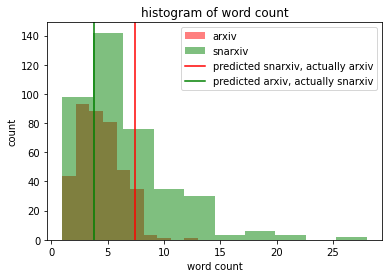

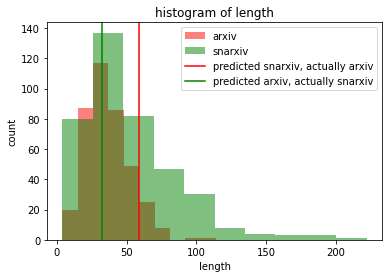

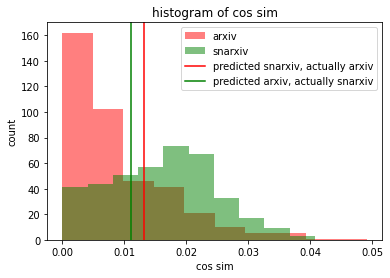

In [21]:
snarxiv_word_ct = snarxiv['title_word_count'].tolist()
arxiv_word_ct = arxiv['title_word_count'].tolist()

plt.hist(arxiv_word_ct, color = 'r', alpha = 0.5, label = 'arxiv')
plt.hist(snarxiv_word_ct, color = 'g', alpha = 0.5, label = 'snarxiv')
plt.axvline(x = 7.461538461538462, color = 'r', label = 'predicted snarxiv, actually arxiv')
plt.axvline(x = 3.7777777777777777, color = 'g', label = 'predicted arxiv, actually snarxiv')
plt.legend()
plt.ylabel('count')
plt.xlabel('word count')
plt.title('histogram of word count')
plt.show()

snarxiv_length = snarxiv['length'].tolist()
arxiv_length = arxiv['length'].tolist()

plt.hist(arxiv_length, color = 'r', alpha = 0.5, label = 'arxiv')
plt.hist(snarxiv_length, color = 'g', alpha = 0.5, label = 'snarxiv')
plt.axvline(x = 58.69230769230769, color = 'r', label = 'predicted snarxiv, actually arxiv')
plt.axvline(x = 32.407407407407405, color = 'g', label = 'predicted arxiv, actually snarxiv')
plt.legend()
plt.ylabel('count')
plt.xlabel('length')
plt.title('histogram of length')
plt.show()

snarxiv_cos = snarxiv['cos_sim'].tolist()
arxiv_cos = arxiv['cos_sim'].tolist()

plt.hist(arxiv_cos, color = 'r', alpha = 0.5, label = 'arxiv')
plt.hist(snarxiv_cos, color = 'g', alpha = 0.5, label = 'snarxiv')
plt.axvline(x = wrong_df[wrong_df['label'] == 'arxiv']['cos_sim'].mean(), color = 'r', 
            label = 'predicted snarxiv, actually arxiv')
plt.axvline(x = wrong_df[wrong_df['label'] == 'snarxiv']['cos_sim'].mean(), color = 'g', 
            label = 'predicted arxiv, actually snarxiv')
plt.legend()
plt.ylabel('count')
plt.xlabel('cos sim')
plt.title('histogram of cos sim')
plt.show()

## Training dataset distributions plots

In [22]:
snarxiv = df[df['label'] == 'snarxiv']
arxiv = df[df['label'] == 'arxiv']

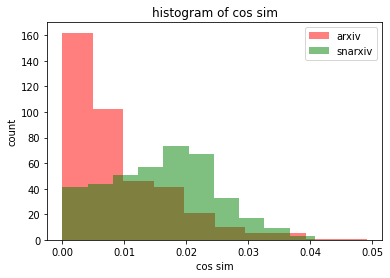

In [23]:
snarxiv_cos = snarxiv['cos_sim'].tolist()
arxiv_cos = arxiv['cos_sim'].tolist()

plt.hist(arxiv_cos, color = 'r', alpha = 0.5, label = 'arxiv')
plt.hist(snarxiv_cos, color = 'g', alpha = 0.5, label = 'snarxiv')
plt.legend()
plt.ylabel('count')
plt.xlabel('cos sim')
plt.title('histogram of cos sim')
plt.show()

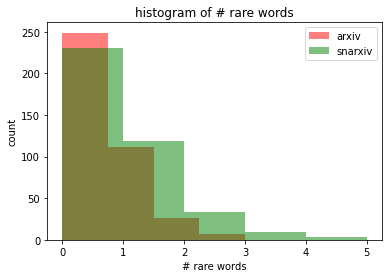

In [24]:
snarxiv_rare = snarxiv['rare_word'].tolist()
arxiv_rare = arxiv['rare_word'].tolist()

plt.hist(arxiv_rare, color = 'r', alpha = 0.5, label = 'arxiv', bins = 4)
plt.hist(snarxiv_rare, color = 'g', alpha = 0.5, label = 'snarxiv', bins = 5)
plt.legend()
plt.ylabel('count')
plt.xlabel('# rare words')
plt.title('histogram of # rare words')
plt.show()

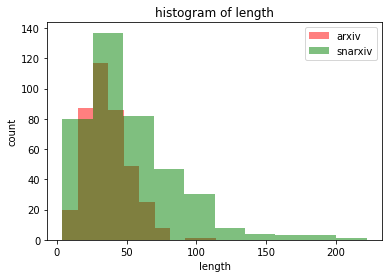

In [26]:
snarxiv_length = snarxiv['length'].tolist()
arxiv_length = arxiv['length'].tolist()

plt.hist(arxiv_length, color = 'r', alpha = 0.5, label = 'arxiv')
plt.hist(snarxiv_length, color = 'g', alpha = 0.5, label = 'snarxiv')
plt.legend()
plt.ylabel('count')
plt.xlabel('length')
plt.title('histogram of length')
plt.show()

## Feature weights

In [25]:
norm = count_concat.iloc[:, -7:]

X = norm.drop(['label'], axis=1)
y = norm[['label']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,random_state = 395786)

svm_classifier = SVC(kernel='linear', probability = True)
svm_classifier.fit(X_train, y_train.values.ravel())
y_pred = svm_classifier.predict(X_test)
svm_accuracy_norare = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
report_df = pd.DataFrame(list(report.split('\n')))
report_df = report_df.rename(columns={0: 'Metrics'})
report_df = report_df[report_df['Metrics'] != '']

print(pd.DataFrame((X.columns, svm_classifier.coef_[0])))

          0                    1               2                 3         4  \
0   cos_sim  ContainsSpecialChar  ContainsNumber  title_word_count    length   
1  0.946694             0.738249        0.687492          0.043794  0.140983   

           5  
0  rare_word  
1  -0.195132  


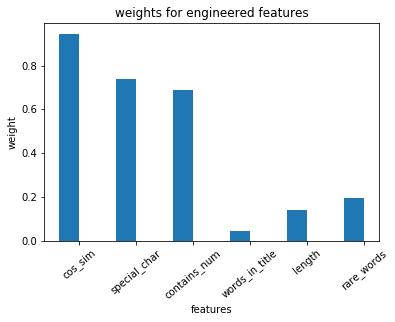

In [26]:
svm_coef = [abs(number) for number in list(svm_classifier.coef_[0])]
features = ['cos_sim', 'special_char', 'contains_num', 'words_in_title', 'length', 'rare_words']

width = 0.35
x = np.arange(len(features)) 
plt.bar(x - width/2, svm_coef, width, label='SVM Coef')
plt.xticks(x, features, rotation = 40)
plt.ylabel('weight')
plt.xlabel('features')
plt.title('weights for engineered features')
plt.show()

## Title analysis

In [27]:
title_vect_nolabel = count_concat.iloc[:,:-7]
label = count_concat[['label']]
title_vect = pd.concat([title_vect_nolabel,label], axis = 1)

X = title_vect.drop(['label'], axis=1)
y = title_vect[['label']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,random_state = 395786)

svm_classifier = SVC(kernel='linear', probability = True)
svm_classifier.fit(X_train, y_train.values.ravel())
y_pred = svm_classifier.predict(X_test)
svm_accuracy_norare = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
report_df = pd.DataFrame(list(report.split('\n')))
report_df = report_df.rename(columns={0: 'Metrics'})
report_df = report_df[report_df['Metrics'] != '']

## Model Prediction: 0 is arxiv, 1 is snarxiv
## Negative weights therefore predict arxiv and vice versa

In [28]:
svm_title_coef = [number for number in list(svm_classifier.coef_[0])]
titles = list(X.columns)
svm_titles_dict = {titles[i]: svm_title_coef[i] for i in range(len(titles))}

### Top words that predict towards arxiv

In [29]:
arxiv_svm_items = sorted(svm_titles_dict.items(), key=lambda x: x[1], reverse=False)[:10]
arxiv_svm_items

[('field', -1.5164019722899633),
 ('aspect', -1.333116993255218),
 ('standard', -1.2361820423192957),
 ('physic', -1.2332695041016248),
 ('kp', -1.1661689492053389),
 ('challenge', -1.1033563839987182),
 ('structure', -0.9248446823909213),
 ('new', -0.8958673161938889),
 ('vacuum', -0.8930283969132038),
 ('super', -0.862437844776516)]

### Top words that predict towards snarxiv

In [30]:
snarxiv_svm_items = sorted(svm_titles_dict.items(), key=lambda x: x[1], reverse=True)[:10]
snarxiv_svm_items

[('model', 2.0206031746721678),
 ('problem', 1.6846156894671573),
 ('instantons', 1.5570264387085384),
 ('progress', 1.442327742549101),
 ('type', 1.3836242470390545),
 ('approach', 1.3594951227379635),
 ('firewall', 1.3434775034305333),
 ('brane', 1.2801058834177745),
 ('reviewing', 1.26369036661346),
 ('cosmic', 1.260978397826878)]

# Validating using the testing dataset

In [152]:
df_test['title'] = df_test['title'].apply(nfx.remove_stopwords)
df_test['title'] = df_test['title'].apply(nfx.remove_punctuations)
df_test = df_test.apply(lambda x: x.astype(str).str.lower())

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df_test['title'] = df_test['title'].map(lemmatize_text)

In [153]:
eng_dict = pd.read_csv('unigram_freq.csv')
eng_list = eng_dict['word'].to_list()

snarxiv = df[df['label'] == 'snarxiv']
arxiv = df[df['label'] == 'arxiv']

tfidf_vectorizer = TfidfVectorizer()
result_vec = tfidf_vectorizer.fit_transform(snarxiv['title'].values.tolist())
snarxiv_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

vect_list = snarxiv_vect.values.tolist()
result_vec = tfidf_vectorizer.transform(df_test['title'].values.tolist())
game_vect = pd.DataFrame(result_vec.todense(), columns=tfidf_vectorizer.get_feature_names())

avg_cos_sim_list = []
for i in range(len(df_test)):
    store_cos_sim = []
    for j in range(len(vect_list)):
        cos_sim = cosine_similarity([vect_list[j]], [game_vect.values.tolist()[i]])
        store_cos_sim.append(cos_sim)
    avg_cos_sim = sum(store_cos_sim) / len(store_cos_sim)
    avg_cos_sim_list.append(avg_cos_sim)
cos_sim_list = [i[0] for i in avg_cos_sim_list]
cos_sim_df = pd.DataFrame(cos_sim_list)

df_testing = pd.concat([df_test, cos_sim_df], axis = 1)
df_testing = df_testing.rename(columns={0: "cos_sim"})


/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [155]:
def rare_words_check(split_txt):
    count = 0
    for word in split_txt:
        if word not in combined_word_dict:
            count += 1
    return count 

df_testing['split_txt'] = [x.split(' ') for x in df_testing['title']]
df_testing['rare_word'] = df_testing['split_txt'].apply(rare_words_check)

special_char = ['^', '=', '$', '{', '}', '+' ,'-', '*', '/', '\\', '$', '#']
df_testing['ContainsSpecialChar'] = df_testing['title'].str.contains('|'.join(map(re.escape, special_char)))
df_testing['ContainsNumber'] = df_testing['title'].str.contains(r'\d', regex=True)
df_testing['title_word_count'] = df_testing['title'].apply(lambda x: len(str(x).split()))
df_testing['length'] = df_testing['title'].str.len()

df_testing = df_testing[['title', 'cos_sim', 'rare_word', 'ContainsSpecialChar', 'ContainsNumber',
                  'title_word_count', 'length', 'label']]

In [162]:
game_vec = vectorizer.transform(df_testing['title'].values.tolist())
game_vect = pd.DataFrame(game_vec.todense(), columns=vectorizer.get_feature_names())

game_concat1 = pd.concat([game_vect, df_testing[['cos_sim', 'ContainsSpecialChar', 'ContainsNumber', 
                                             'title_word_count', 'length', 
                                             'rare_word','label']].reset_index()], axis = 1)

game_concat1 = game_concat1.drop(columns = 'index')

game_concat1['cos_sim'] = (game_concat1['cos_sim'] - cos_mean) / cos_std

game_concat1['ContainsSpecialChar'] = game_concat1['ContainsSpecialChar'].astype(int)

game_concat1['ContainsNumber'] = game_concat1['ContainsNumber'].astype(int)

if title_std != 0:
    game_concat1['title_word_count'] = (game_concat1['title_word_count'] - title_mean) / title_std

if len_std != 0:
    game_concat1['length'] = (game_concat1['length'] - len_mean) / len_std

if rare_std != 0:
    game_concat1['rare_word'] = (game_concat1['rare_word'] - rare_mean) / rare_std

/Users/shawnyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [164]:
X = game_concat1.drop(['label'], axis=1)
y = game_concat1[['label']]

In [166]:
y_pred = svm_classifier.predict(X)
svm_accuracy_norare = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)
report_df = pd.DataFrame(list(report.split('\n')))
report_df = report_df.rename(columns={0: 'Metrics'})
report_df = report_df[report_df['Metrics'] != '']
print(svm_accuracy_norare)
print(report_df)

0.89
                                             Metrics
0                precision    recall  f1-score   ...
2         arxiv       0.84      0.96      0.90   ...
3       snarxiv       0.95      0.82      0.88   ...
5      accuracy                           0.89   ...
6     macro avg       0.90      0.89      0.89   ...
7  weighted avg       0.90      0.89      0.89   ...
